After the **previous modeling**, we faced some challenges. Therefore, we decided to **split the available data (5 governorates)** into two parts:  

- **Training:** 3 governorates (**Dakahlia, Fayoum, and Matrouh**)  
- **Testing:** 2 governorates (**reserved for evaluating the application**)  

In this notebook, we use the **best-performing model** from the previous experiments we made and **train it on the selected training data**.  

At the end of the notebook, we **save both the preprocessing pipeline and the trained model**.  
This way, any **new data provided by a user** will first go through the **same preprocessing steps** before being passed into the model to **generate predictions for desertification** in the **desired location**.  

# **Desertification Dataset CSV File Structure**

This notebook uses a dataset collected from **Google Earth Engine (GEE)** for three Egyptian governorates: **Dakahlia, Fayoum, Matrouh**.  
The dataset includes **NDVI values**, **geographic coordinates** (longitude & latitude), **soil properties**, and **population data**.  

All CSV files contain the following columns:

| Column      | Description |
|------------|-------------|
| longitude  | Longitude of the sample point |
| latitude   | Latitude of the sample point |
| year       | Year of the observation |
| month      | Month of the observation |
| area       | Region name |
| ndvi       | Normalized Difference Vegetation Index (NDVI) from MODIS, range -1 to 1 |
| t2m_c      | Temperature at 2 meters (°C) |
| td2m_c     | Dewpoint temperature at 2 meters (°C) |
| rh_pct     | Relative humidity (%) |
| tp_m       | Total precipitation (meters) |
| ssrd_jm2   | Surface solar radiation downward (J/m²) |
| LC_Type1   | Land cover type from WorldCover |
| sand       | Soil sand fraction (%) |
| silt       | Soil silt fraction (%) |
| clay       | Soil clay fraction (%) |
| soc        | Soil organic carbon (%) |
| ph         | Soil pH |
| bdod       | Soil bulk density (g/cm³) |
| cec        | Soil cation exchange capacity (cmol/kg) |
| POP        | Population from WorldPop |


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.6 MB/s eta 0:00:00


# **Data Gathering**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/grad_project_data/des3_df.csv'

In [ ]:
des_df = pd.read_csv(file_path)

In [ ]:
print("Data shape:", des_df.shape)

Data shape: (104363, 20)


In [ ]:
des_df.head()

,longitude,latitude,year,month,area,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,LC_Type1,sand,silt,clay,soc,ph,bdod,cec,POP
0,31.158066,30.286700,2025,1,Dakahlia,0.70215,15.561177,7.861838,60.125874,0.015587,5.885828e+09,40,424,298,279,369,72,134,195,3.509249
1,31.113150,30.610094,2025,1,Dakahlia,0.51000,15.568003,8.534099,62.907192,0.034528,5.727603e+09,50,385,279,337,334,75,129,185,10.245003
2,31.310780,30.295683,2025,1,Dakahlia,0.59845,15.485617,7.735447,59.899883,0.014093,5.903953e+09,50,426,255,319,298,74,131,186,157.432000
3,31.256880,30.430430,2025,1,Dakahlia,0.57405,15.449718,7.959476,60.961070,0.022374,5.851018e+09,40,399,270,330,372,74,133,187,22.209887
4,31.445526,30.565178,2025,1,Dakahlia,0.53560,15.528049,8.544456,63.112797,0.024161,5.755267e+09,50,327,284,390,331,74,133,190,161.653430


# **Feature Engineering**

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

des_df['season'] = des_df['month'].apply(get_season)

In [ ]:
# soil ratios
des_df['soil_total'] = des_df['sand'] + des_df['silt'] + des_df['clay']
# avoid division by zero
des_df['soil_total'] = des_df['soil_total'].replace(0, np.nan)
des_df['sand_ratio'] = des_df['sand'] / des_df['soil_total']
des_df['silt_ratio'] = des_df['silt'] / des_df['soil_total']
des_df['clay_ratio'] = des_df['clay'] / des_df['soil_total']
des_df = des_df.drop(columns=['soil_total'])

In [ ]:
# combined feature
des_df['soc_cec'] = des_df['soc'] * des_df['cec']

# **Preprocessor Pipeline**

In [ ]:
des_df.shape

(104363, 25)

In [ ]:
target_col = 'ndvi'
y = des_df[target_col]
X = des_df.drop(columns=[target_col])

In [ ]:
categorical_features = ['season', 'area']

In [ ]:
numeric_features = [c for c in X.columns if c not in categorical_features]

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_valid_trans = preprocessor.transform(X_valid)

In [ ]:
# Helper to get transformed feature names
try:
    feat_names = preprocessor.get_feature_names_out()
except Exception:
    num_names = numeric_features
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_cols = []
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_cols = list(cat_encoder.get_feature_names_out(categorical_features))
    else:
        cat_cols = list(cat_encoder.get_feature_names(categorical_features))
    feat_names = np.concatenate([num_names, cat_cols])

print("Number of transformed features:", len(feat_names))

Number of transformed features: 27


# **Model Training & Hyperparameter Tuning**

In [ ]:
import lightgbm as lgb

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_estimators': 1000,
        'random_state': 42,
        'verbosity': -1
    }

    model = LGBMRegressor(**params)

    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

    model.fit(
        X_train_trans, y_train,
        eval_set=[(X_valid_trans, y_valid)],
        eval_metric='rmse',
        callbacks=callbacks,
    )

    preds = model.predict(X_valid_trans)
    mse = mean_squared_error(y_valid, preds)
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
n_trials = 50
print(f"Starting Optuna tuning ({n_trials} trials)...")
study.optimize(objective, n_trials=n_trials)

[I 2025-09-11 14:23:17,634] A new study created in memory with name: no-name-8e20c7b7-82fd-4342-8031-dcaaf8238ee6


Starting Optuna tuning (50 trials)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-11 14:23:50,884] Trial 0 finished with value: 0.0031767054714432674 and parameters: {'learning_rate': 0.004009014172093557, 'num_leaves': 974, 'max_depth': 11, 'min_child_samples': 101, 'subsample': 0.681961756402087, 'colsample_bytree': 0.6830558625585996, 'reg_alpha': 2.206303602399257, 'reg_lambda': 0.0012302994300822786}. Best is trial 0 with value: 0.0031767054714432674.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-11 14:24:27,360] Trial 1 finished with value: 0.0015774756611721585 and parameters: {'learning_rate': 0.018811578289204503, 'num_leaves': 2333, 'max_depth': 10, 'min_child_samples': 57, 'subsample': 0.5382286845191452, 'c

In [ ]:
print("Best MSE (validation):", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Best MSE (validation): 0.0011408651993588532
Best params:
  learning_rate: 0.037150642557572236
  num_leaves: 1569
  max_depth: 13
  min_child_samples: 6
  subsample: 0.5589418720185837
  colsample_bytree: 0.5823944081971174
  reg_alpha: 0.0007226150527033457
  reg_lambda: 5.199538743639425


In [ ]:
best_params = study.best_params
best_params.update({'n_estimators': 2000, 'random_state': 42, 'verbosity': -1})
final_model = LGBMRegressor(**best_params)

In [ ]:
import lightgbm as lgb

callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

final_model.fit(
    X_train_trans, y_train,
    eval_set=[(X_valid_trans, y_valid)],
    eval_metric='rmse',
    callbacks=callbacks,
)

LGBMRegressor(colsample_bytree=0.5823944081971174,
              learning_rate=0.037150642557572236, max_depth=13,
              min_child_samples=6, n_estimators=2000, num_leaves=1569,
              random_state=42, reg_alpha=0.0007226150527033457,
              reg_lambda=5.199538743639425, subsample=0.5589418720185837,
              verbosity=-1)

In [ ]:
# Evaluate on validation
y_pred = final_model.predict(X_valid_trans)
mse_final = mean_squared_error(y_valid, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_valid, y_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
print("Final Optuna-tuned LightGBM results on validation set:")
print(f"MSE: {mse_final:.6f}")
print(f"RMSE: {rmse_final:.6f}")
print(f"R2: {r2_final:.6f}")

Final Optuna-tuned LightGBM results on validation set:
MSE: 0.001110
RMSE: 0.033316
R2: 0.970431


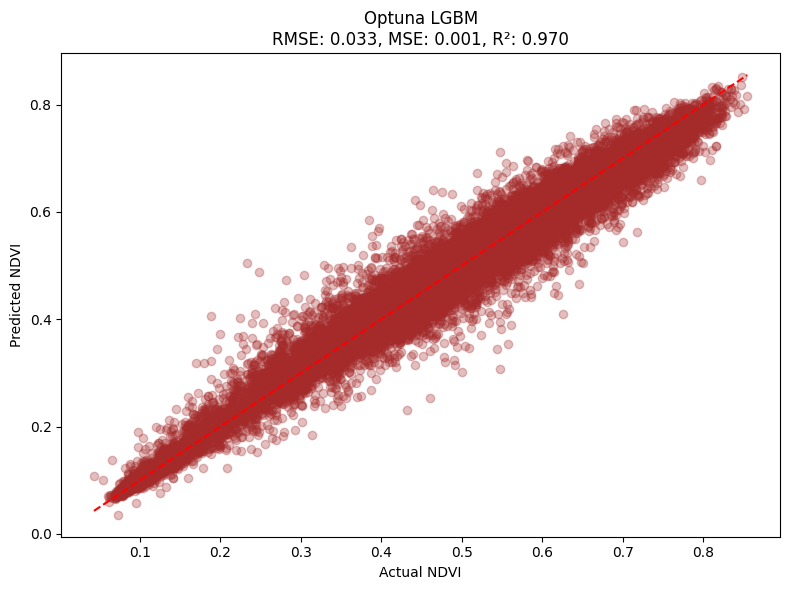

In [ ]:
# Scatter Plot: Actual vs Predicted NDVI
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.3, color='brown')
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Optuna LGBM\nRMSE: {rmse_final:.3f}, MSE: {mse_final:.3f}, R²: {r2_final:.3f}")
plt.tight_layout()
plt.show()

# **Save model & preprocessing for AI API**

In [ ]:
import joblib
import os
import json

In [ ]:
# Create folder to save artifacts
os.makedirs("model_artifacts", exist_ok=True)

In [ ]:
joblib.dump(final_model, "model_artifacts/model.pkl")

['model_artifacts/model.pkl']

In [ ]:
joblib.dump(preprocessor, "model_artifacts/preprocessor.pkl")

['model_artifacts/preprocessor.pkl']

In [ ]:
with open("model_artifacts/feature_names.json", "w") as f:
    json.dump(X.columns.tolist(), f)

In [ ]:
joblib.dump(final_model, "final_model_compressed.pkl", compress=("xz", 3))

['final_model_compressed.pkl']